In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from typing import Union

from matplotlib import ticker
import numpy as np
import json
import country_converter as coco
from datetime import datetime, timedelta
import requests
import pandas as pd
import geopandas as gpd
# https://www.relataly.com/visualize-covid-19-data-on-a-geographic-heat-maps/291/
# https://www.citypopulation.de/en/germany/cities/
# https://www-genesis.destatis.de/genesis//online?operation=table&code=12411-0010&bypass=true&levelindex=0&levelid=1705062410665#abreadcrumb

In [8]:
Data = pd.read_excel('../dat/surveillance_data.xlsx', sheet_name=None)

data = Data['2020_surveillance']

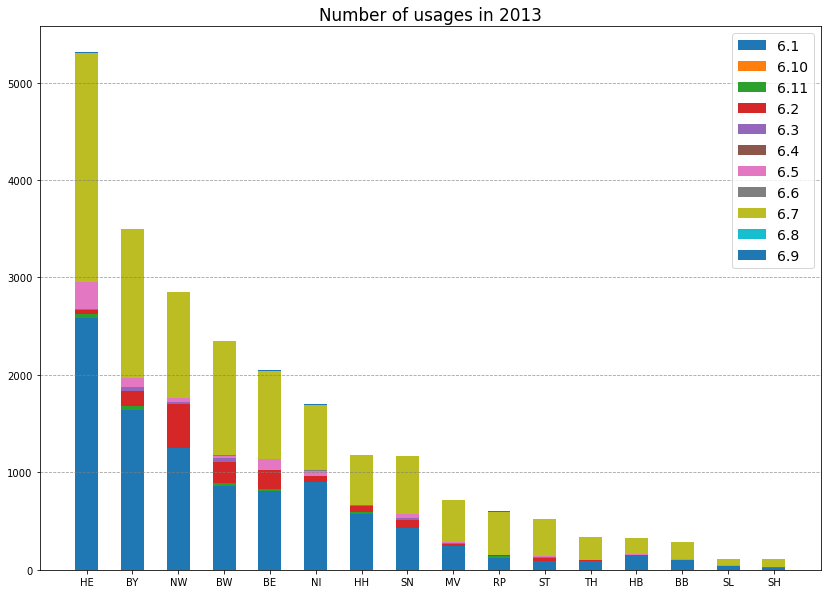

In [9]:
def plot_paragraphs_for_regions(data: Union[dict, None], year: str = None) -> None:
    """
    Barplot with bins split by metapargraph 6.x
    
    arguments:
    data -- dataframe in survilance data format or dict read from xlsx file
    year -- year to plot. provide None if data is dataframe
    """
    data = data[year + '_surveillance'] if year else data
    data['metaparagraph'] = data.subparagraph.apply(lambda x: '.'.join(x.split('.')[:2]))
    
    fig, ax = plt.subplots(figsize = (14, 10))
    plt.rcParams.update({'font.size': 14})

    data_summed_ = data.query('paragraph==6').groupby('metaparagraph').sum()
    data_summed = data_summed_[data_summed_.sum()[-18:-2].sort_values(ascending=False).index]

    regions = data_summed.columns
    bottom = np.zeros(len(regions))

    weight_counts = {
        i: np.array(data_summed.loc[i]) for i in data_summed.index
    }
    width = 0.5

    for boolean, weight_count in weight_counts.items():
        p = ax.bar(regions, weight_count, width, label=boolean, bottom=bottom)
        bottom = bottom + weight_count

    ax.set_title(f"Number of usages in {year}")
    ax.legend(loc="upper right")
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(1e3))
    # ax.yaxis.set_minor_locator(ticker.MultipleLocator(5e2))
    ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.75)
    ax.yaxis.grid(True, linestyle='--', which='minor', color='grey', alpha=.25)
    # ax.set_ylim(0, 6e3)
    # ax.show()
    return None


plot_paragraphs_for_regions(Data, year='2013')

In [11]:
SHAPEFILE = '../dat/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp'
geo_df = gpd.read_file(SHAPEFILE)
geo_df = geo_df[geo_df.admin == 'Germany'][['iso_3166_2', 'name', 'geometry', 'latitude', 'longitude']]
geo_df['state'] = geo_df.iso_3166_2.apply(lambda x: x.split('-')[1])
geo_df['coords'] = geo_df.geometry.apply(lambda x: x.representative_point().coords[:][0])


In [13]:
def data_to_geo(data_xl: dict, data_geo: pd.DataFrame, population_data: pd.DataFrame, year: str) -> pd.DataFrame:
    """
    Function to prepare surveillance data for geo plots.
    
    arguments:
    data_xl -- dict read from xlsx file
    data_geo -- geopandas data for german states
    population_data -- dataframe with number of citizens per state per year
    year -- year to prepare
    """
    data = data_xl[year + '_surveillance']
    data_agg = data.query('paragraph in (3,6)').groupby('paragraph').sum().T.reset_index(drop=False)
    data_agg.columns = ['state', 'cases_3', 'cases_6']
    population_data = population_data[['state', year]].rename(columns={year: 'population'})
    geo_df_cases = geo_df.merge(data_agg, on = 'state').merge(population_data, on='state')
    geo_df_cases['cases_3_per_1k'] = geo_df_cases.cases_3/geo_df_cases.population * 1000
    geo_df_cases['cases_6_per_1k'] = geo_df_cases.cases_6/geo_df_cases.population * 1000
    return geo_df_cases

population = pd.read_csv('../dat/12411-0010-DLAND_population.csv')
geo_df_cases = data_to_geo(Data, geo_df, population, '2021')
geo_df_cases.head(3)

,iso_3166_2,name,geometry,latitude,longitude,state,coords,cases_3,cases_6,population,cases_3_per_1k,cases_6_per_1k
0,DE-SN,Sachsen,"POLYGON ((14.39781 51.01311, 14.38675 51.01327...",51.0053,13.45960,SN,"(13.508442582469637, 50.914464417000076)",243,535,4043002,0.060104,0.132327
1,DE-BY,Bayern,"POLYGON ((12.10134 50.31398, 12.07614 50.31517...",49.0056,11.39660,BY,"(12.042583660459771, 48.916497707653036)",1203,3905,13176989,0.091296,0.29635
2,DE-RP,Rheinland-Pfalz,"POLYGON ((6.10116 50.06341, 6.09940 50.06413, ...",49.8685,7.36974,RP,"(7.262248004757661, 49.946849060500085)",270,526,4106485,0.06575,0.12809


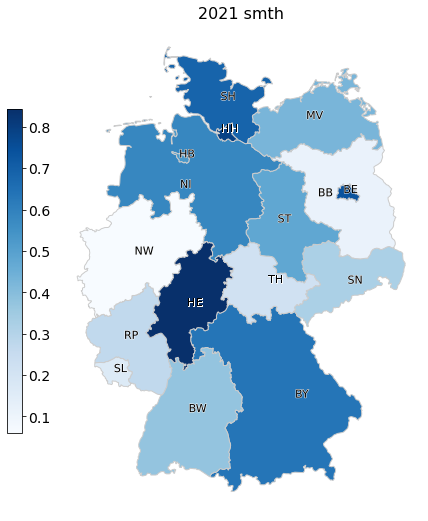

In [14]:
def plot_map(geo_df: pd.DataFrame, column: str, title: str = None, figname: str = None) -> None:
    """
    Plot german map with colorbar.
    
    arguments:
    geo_df -- data prepared with `data_to_geo`
    column -- value which is used to indicate levels across states, e.g. 'cases_3_per_1k'
    title -- plot titile
    figname -- if provided save figure, e.g. 'map_rel_2021.png'
    """
    cmap = 'Blues' # can use other like 'Reds'
    fig, ax = plt.subplots(1, figsize=(20, 9))

    ax = geo_df_cases.plot(column=column, ax=ax, edgecolor='0.8', linewidth=1, cmap=cmap)
    ax.set_title(title, fontdict={'fontsize': '16', 'fontweight': '3'})

    for idx, row in geo_df_cases.iterrows():
        x = row['coords'][0] - 0.1
        y = row['coords'][1]
        text = plt.annotate(
            text=f"{row['state']}",
            xy=(x,y),
            xytext= (x,y), 
            fontsize=11,
            color='black',
        )
        text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='white'),
                           path_effects.Normal()])

    ax.axis('off')
    
    vmin, vmax = geo_df_cases[column].min(), geo_df_cases[column].max()
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)
    cbaxes = fig.add_axes([0.35, 0.25, 0.01, 0.5])
    cbar = fig.colorbar(sm, cax=cbaxes)
    if figname:
        plt.savefig(figname, dpi=400)
        
plot_map(geo_df_cases, 'cases_6_per_1k', '2021 smth')